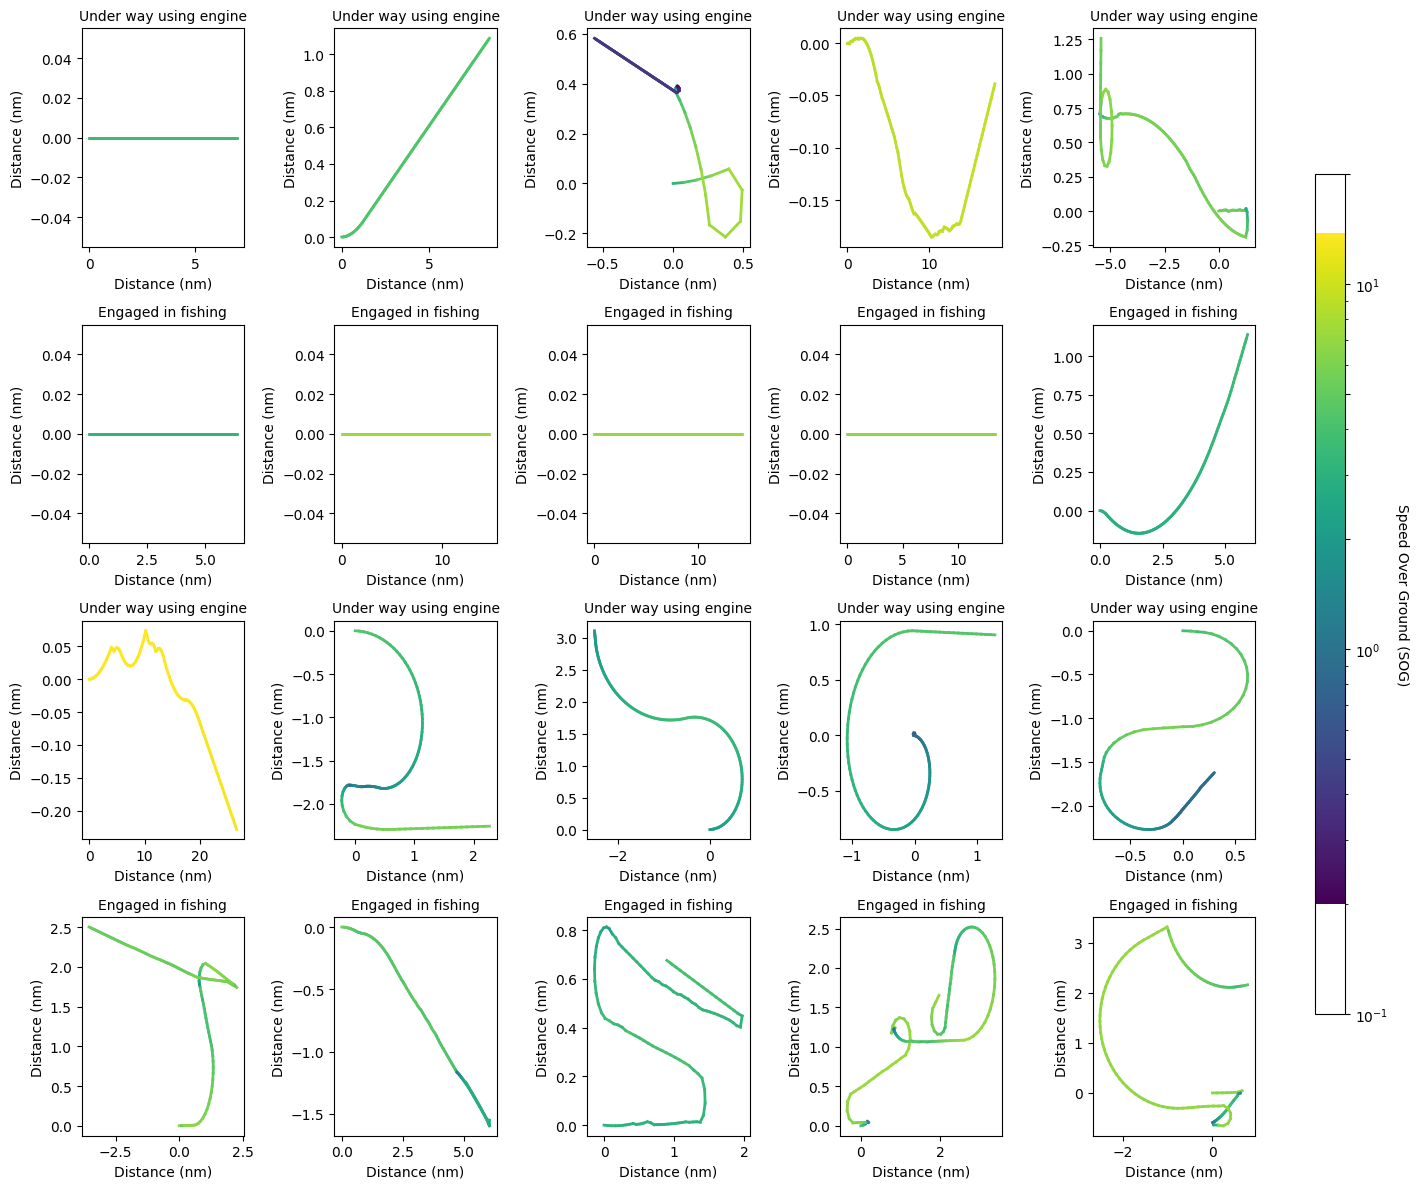

Visualization completed for balanced classes of misclassified and correctly classified files.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

# Define paths
misclassified_file = "2h_LSTM_2_2_misclassified_summary_99.csv"
input_folder = "../5_Data_Pipeline/time_sets_st_shortened"

# Read misclassified summary and get the top 10 misclassified files
df_misclassified = pd.read_csv(misclassified_file)
df_misclassified_sorted = df_misclassified.sort_values(by="misclassified", ascending=False)

# Separate misclassified files into two groups based on navigational status
misclassified_ue = []  # Under way using engine
misclassified_ef = []  # Engaged in fishing
for file_name in df_misclassified_sorted["file"].tolist():
    file_path = os.path.join(input_folder, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        status = data['Navigational status'].iloc[0] if 'Navigational status' in data.columns else 'Unknown'
        if status == "Under way using engine" and len(misclassified_ue) < 5:
            misclassified_ue.append(file_name)
        elif status == "Engaged in fishing" and len(misclassified_ef) < 5:
            misclassified_ef.append(file_name)
        if len(misclassified_ue) == 5 and len(misclassified_ef) == 5:
            break  # Stop once we've reached 5 vessels in each category

# Separate correctly classified files into two groups based on navigational status
correctly_classified_ue = []  # Under way using engine
correctly_classified_ef = []  # Engaged in fishing
for file_name in df_misclassified_sorted[::-1]["file"].tolist():  # Start from the bottom of the sorted list
    file_path = os.path.join(input_folder, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        status = data['Navigational status'].iloc[0] if 'Navigational status' in data.columns else 'Unknown'
        if status == "Under way using engine" and len(correctly_classified_ue) < 5:
            correctly_classified_ue.append(file_name)
        elif status == "Engaged in fishing" and len(correctly_classified_ef) < 5:
            correctly_classified_ef.append(file_name)
        if len(correctly_classified_ue) == 5 and len(correctly_classified_ef) == 5:
            break  # Stop once we've reached 5 vessels in each category

# Combine all selected files
all_files = misclassified_ue + misclassified_ef + correctly_classified_ue + correctly_classified_ef

# Compute global SOG range
global_min_sog, global_max_sog = float("inf"), float("-inf")
for file_name in all_files:
    file_path = os.path.join(input_folder, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        if 'SOG' in data.columns:
            global_min_sog = min(global_min_sog, data['SOG'].min())
            global_max_sog = max(global_max_sog, data['SOG'].max())

# Ensure valid min/max SOG values
global_min_sog = max(global_min_sog, 0.1)
global_max_sog = max(global_max_sog, 1.0)

# Set up colormap
norm = LogNorm(vmin=global_min_sog, vmax=global_max_sog)
cmap = plt.cm.viridis
sm = ScalarMappable(cmap=cmap, norm=norm)

def visualize_vessel_path(file_path, status, ax):
    try:
        data = pd.read_csv(file_path)
        if not {'Timestamp', 'SOG', 'COG', 'Navigational status'}.issubset(data.columns):
            print(f"Skipping {file_path}: Missing required columns.")
            return
        
        # Convert timestamp
        data['Timestamp'] = pd.to_datetime(data['Timestamp'])
        data['time_diff'] = data['Timestamp'].diff().dt.total_seconds() / 3600
        data.loc[0, 'time_diff'] = 0
        
        # Compute relative positions
        data['x'] = data['SOG'] * data['time_diff'] * np.cos(np.deg2rad(data['COG']))
        data['y'] = data['SOG'] * data['time_diff'] * np.sin(np.deg2rad(data['COG']))
        data['x_cum'], data['y_cum'] = data['x'].cumsum(), data['y'].cumsum()
        
        # Plot vessel path
        for i in range(len(data) - 1):
            ax.plot(
                [data['x_cum'].iloc[i], data['x_cum'].iloc[i + 1]],
                [data['y_cum'].iloc[i], data['y_cum'].iloc[i + 1]],
                color=cmap(norm(data['SOG'].iloc[i])),
                linewidth=2
            )
        
        # Labels and title
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel('Distance (nm)')
        ax.set_title(f"{status}", fontsize=10)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create subplots for multiple images
cols = 5
rows = 4  # Two rows for misclassified and two rows for correctly classified
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

for idx, file_name in enumerate(all_files):
    if idx >= len(axes):
        break  # Avoid accessing non-existent subplot axes
    
    input_path = os.path.join(input_folder, file_name)
    if not os.path.exists(input_path):
        print(f"File not found: {input_path}")
        continue
    
    data = pd.read_csv(input_path)
    status = data['Navigational status'].iloc[0] if 'Navigational status' in data.columns else 'Unknown'
    visualize_vessel_path(input_path, status, axes[idx])

# Remove unused subplots
for idx in range(len(all_files), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout to prevent overlap
fig.tight_layout(rect=[0, 0, 0.85, 1])

# Add colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Speed Over Ground (SOG)', rotation=270, labelpad=15)
cbar.set_ticks([0.1, 0.5, 1, 2, 5, 10, 20])

plt.show()

print("Visualization completed for balanced classes of misclassified and correctly classified files.")